In [1]:
import pm4py


In [2]:
from pm4py.objects.log.importer.xes import factory as xes_import_factory
log = xes_import_factory.apply("C:/Users/Daniel/Documents/Event logs/RequestForPayment.xes.gz")

In [3]:
from pm4py.objects.log.util import sampling
sampled_log = sampling.sample(log, n=5)
for t in sampled_log:
    print(t)

{'attributes': {'Rfp_id': 'request for payment 163752', 'Project': 'project 147546', 'Task': 'UNKNOWN', 'concept:name': 'request for payment 163752', 'OrganizationalEntity': 'organizational unit 65454', 'Cost Type': 0, 'RequestedAmount': 246.48981088281454, 'Activity': 'UNKNOWN', 'RfpNumber': 'request for payment number 163753'}, 'events': [{'id': 'st_step 163755_0', 'org:resource': 'STAFF MEMBER', 'concept:name': 'Request For Payment SUBMITTED by EMPLOYEE', 'time:timestamp': datetime.datetime(2018, 4, 30, 8, 59, 3, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'org:role': 'EMPLOYEE'}, '..', {'id': 'rp_request for payment 163752_16', 'org:resource': 'SYSTEM', 'concept:name': 'Payment Handled', 'time:timestamp': datetime.datetime(2018, 5, 3, 17, 31, 17, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'org:role': 'UNDEFINED'}]}
{'attributes': {'Rfp_id': 'request for payment 157727', 'Project': 'project 147551', 'Task': 'UNKNOWN', 'concept:name': 'request for p

In [4]:
from pm4py.statistics.traces.log import case_statistics

var_with_count = case_statistics.get_variant_statistics(log, parameters={"max_variants_to_return": 5})
var_with_count

[{'variant': 'Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by ADMINISTRATION,Request For Payment FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled',
  'count': 3011},
 {'variant': 'Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by ADMINISTRATION,Request For Payment APPROVED by BUDGET OWNER,Request For Payment FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled',
  'count': 1762},
 {'variant': 'Request For Payment SUBMITTED by EMPLOYEE,Request For Payment FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled',
  'count': 583},
 {'variant': 'Request For Payment SUBMITTED by EMPLOYEE,Request For Payment REJECTED by ADMINISTRATION,Request For Payment REJECTED by EMPLOYEE',
  'count': 343},
 {'variant': 'Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by PRE_APPROVER,Request For Payment FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled',
  'count': 340}]

In [5]:
from pm4py.algo.filtering.log.variants import variants_filter

filtered_log = variants_filter.filter_log_variants_percentage(log, percentage=.8)

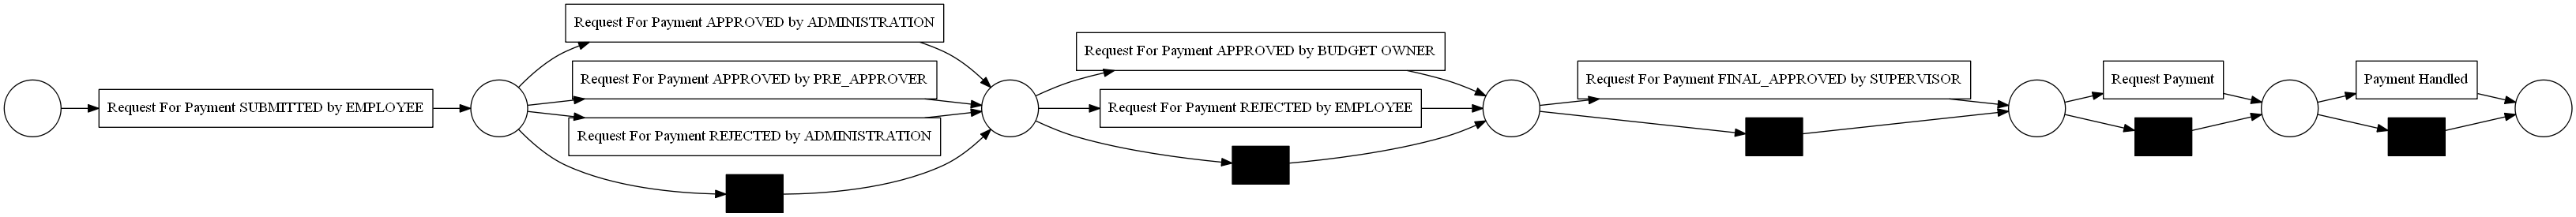

In [6]:
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.visualization.petrinet import factory as visualizer

net, initial, final = inductive_miner.apply(filtered_log)
gviz = visualizer.apply(net)
visualizer.view(gviz)

In [7]:
import pandas as pd

class Queue:

    def __init__(self):
        self.entries = []
        self.exits = []

    def enter(self, time):
        self.entries.append(time)

    def exit(self, time):
        self.exits.append(time)

    def get_data(self) -> pd.DataFrame:
        return pd.DataFrame(data={'entries' : self.entries, 'exits' : self.exits})


In [8]:
import datetime

def loop(log: pm4py.objects.log, activity: str):
    q = Queue()
    last_time: datetime.datetime = None
    for trace in log:
        for event in trace:
            if event['concept:name'] == activity and last_time is not None:
                q.enter(last_time)
                q.exit(event['time:timestamp'])

            last_time = event['time:timestamp']
    return q

In [9]:
q = loop(filtered_log, 'Request For Payment FINAL_APPROVED by SUPERVISOR')
df = q.get_data()

In [10]:
df = df.sort_values('entries')
df['wait'] = df['exits'] - df['entries']
df.head()

entries                      exits     wait
4773  2017-01-09 10:30:48+01:00  2017-01-09 10:31:42+01:00 00:00:54
4774  2017-01-10 14:56:59+01:00  2017-01-10 14:57:53+01:00 00:00:54
4775  2017-01-10 15:02:39+01:00  2017-01-10 15:02:53+01:00 00:00:14
5356  2017-01-10 15:19:04+01:00  2017-01-10 15:26:13+01:00 00:07:09
4776  2017-01-10 17:19:05+01:00  2017-01-11 09:54:26+01:00 16:35:21

In [11]:
interarrival = pd.DataFrame()
interarrival['entries'] = df['entries'].diff()[1:]
interarrival['exits'] = df['exits'].sort_values().diff()[1:]
interarrival.head()

entries           exits
4774 1 days 04:26:11 1 days 04:26:11
4775 0 days 00:05:40 0 days 00:05:00
5356 0 days 00:16:25 0 days 00:23:20
4776 0 days 02:00:01 0 days 18:28:13
4777 0 days 18:29:35 0 days 01:54:25

In [12]:
interarrival = interarrival.astype('timedelta64[s]')


Bad key "text.kerning_factor" on line 4 in
C:\Users\Daniel\anaconda3\envs\WebMiningAssignments\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


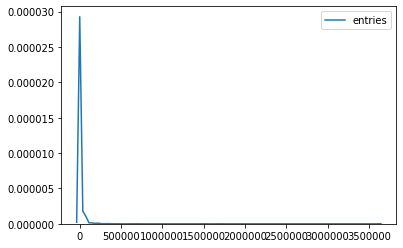

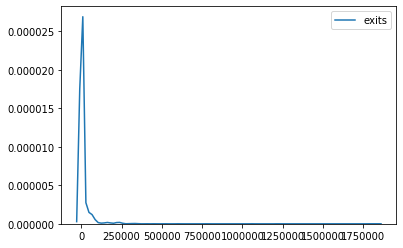

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.kdeplot(interarrival.entries)
plt.show()
sns.kdeplot(interarrival.exits)
plt.show()

In [14]:
entries = df.entries.map(lambda dt: dt.timestamp())
exits = df.exits.map(lambda dt: dt.timestamp())
waits = df.wait.astype('timedelta64[s]')

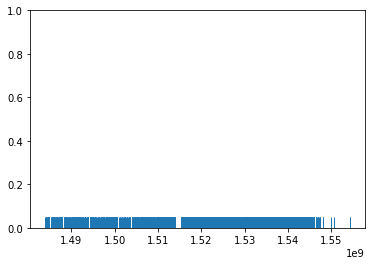

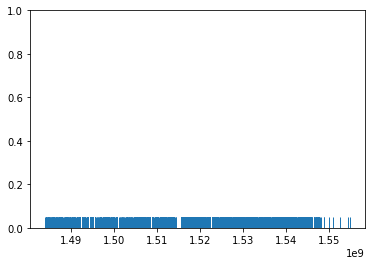

In [15]:
sns.rugplot(entries)
plt.show()
sns.rugplot(exits)
plt.show()

In [16]:
import numpy as np

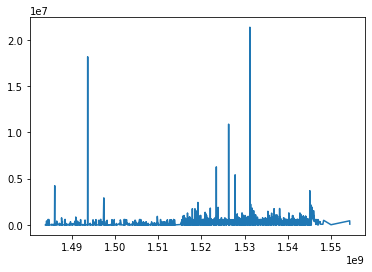

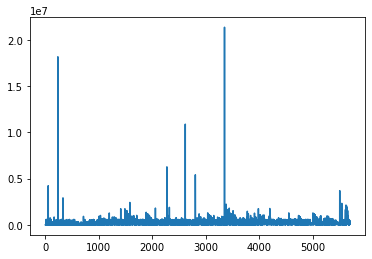

In [17]:
plt.plot(entries, waits)
plt.show()
plt.plot(np.arange(len(waits)), waits)

In [18]:
print(entries.head())
print(entries[0])
print(entries.iloc[0])

4773    1.483954e+09
4774    1.484057e+09
4775    1.484057e+09
5356    1.484058e+09
4776    1.484065e+09
Name: entries, dtype: float64
1515361360.0
1483954248.0


In [28]:
def replay_queue(queue: Queue):
    v = queue.get_data()
    w = v.exits - v.entries
    en = v.entries.sort_values()
    ex = v.exits.sort_values()

    n = len(v)
    idx, idy = 0, 0
    tokens = 0
    FIFO, LIFO, SPT, Q_gt1 = 0, 0, 0, 0
    running_ups = []
    
    cont_positions = []
    
    token_ts = []
    
    while idx < n:
        while idx < n and en.iloc[idx] <= ex.iloc[idy]:
            up = en.index[idx]
            running_ups.append(up)
            tokens += 1
            token_ts.append(tokens)
            idx += 1
        while idy < n and (idx == n or en.iloc[idx] > ex.iloc[idy]):
            down = ex.index[idy]

            if tokens > 1:    
                spt = w.loc[running_ups].min()
                pt = w.loc[down]
                if pt == spt:
                    SPT += 1
                
                pos = running_ups.index(down)
                cont_positions.append(pos / float(tokens - 1))
                
                if pos == 0:
                    FIFO += 1
                elif pos == tokens - 1:
                    LIFO += 1

                Q_gt1 += 1

                running_ups.remove(down)
            else:
                running_ups.clear()

            tokens -= 1
            token_ts.append(tokens)
            idy += 1

    print(Q_gt1)
    print(FIFO, FIFO / Q_gt1)
    print(LIFO, LIFO / Q_gt1)
    print(SPT, SPT / Q_gt1)

    print(np.mean(cont_positions))

    return token_ts


In [29]:
token_ts = replay_queue(q)

5645
76 0.013463241806908768
868 0.1537643932683791
1777 0.31479185119574843
0.5793276121118575


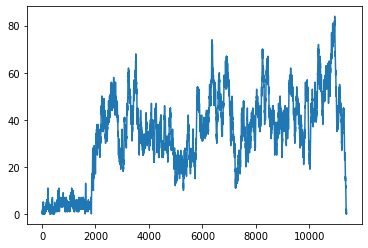

In [30]:
plt.plot(token_ts)

['cauchy', 'chi2', 'expon', 'exponpow', 'gamma', 'lognorm', 'norm', 'powerlaw', 'rayleigh', 'uniform']
Fitted cauchy distribution with error=5.650971443424009e-10)


C:\Users\Daniel\anaconda3\envs\WebMiningAssignments\lib\site-packages\scipy\stats\_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


SKIPPED chi2 distribution (taking more than 30 seconds)
Fitted expon distribution with error=3.8825095015720576e-11)


C:\Users\Daniel\anaconda3\envs\WebMiningAssignments\lib\site-packages\scipy\stats\_distn_infrastructure.py:2406: RuntimeWarning: invalid value encountered in sqrt
  Shat = sqrt(mu2hat / mu2)
C:\Users\Daniel\anaconda3\envs\WebMiningAssignments\lib\site-packages\scipy\stats\_continuous_distns.py:1656: RuntimeWarning: overflow encountered in exp
  f = 1 + np.log(b) + sc.xlogy(b - 1.0, x) + xb - np.exp(xb)
C:\Users\Daniel\anaconda3\envs\WebMiningAssignments\lib\site-packages\scipy\stats\_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


Fitted exponpow distribution with error=6.244647109942934e-10)
Fitted gamma distribution with error=6.238917335308876e-10)
SKIPPED lognorm distribution (taking more than 30 seconds)
Fitted norm distribution with error=3.733110809345265e-10)
SKIPPED powerlaw distribution (taking more than 30 seconds)
Fitted rayleigh distribution with error=2.897209273226203e-10)
Fitted uniform distribution with error=6.168023874679798e-10)


sumsquare_error            aic            bic  kl_div
expon        3.882510e-11   31134.298253 -185749.608422     inf
rayleigh     2.897209e-10   98035.395656 -174303.505133     inf
norm         3.733111e-10  102860.120344 -172859.857206     inf
cauchy       5.650971e-10    4468.208219 -170498.792305     inf
uniform      6.168024e-10    3023.987603 -170000.189134     inf

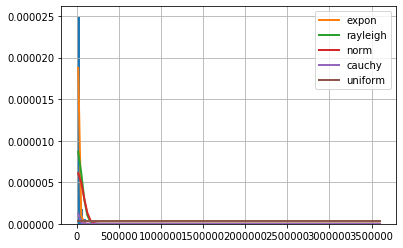

In [31]:
from fitter import Fitter
from fitter import get_common_distributions
print(get_common_distributions())
f = Fitter(data=interarrival.entries, distributions=get_common_distributions())
f.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
f.summary()

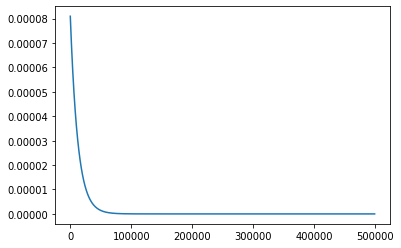

C:\Users\Daniel\anaconda3\envs\WebMiningAssignments\lib\site-packages\scipy\stats\_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


In [43]:
import scipy.stats 
param = f.fitted_param['expon']
print(param)
dist = scipy.stats.expon
plt.plot(np.arange(0, 500000, 1000), dist.pdf(np.arange(0, 500000, 1000), *param))

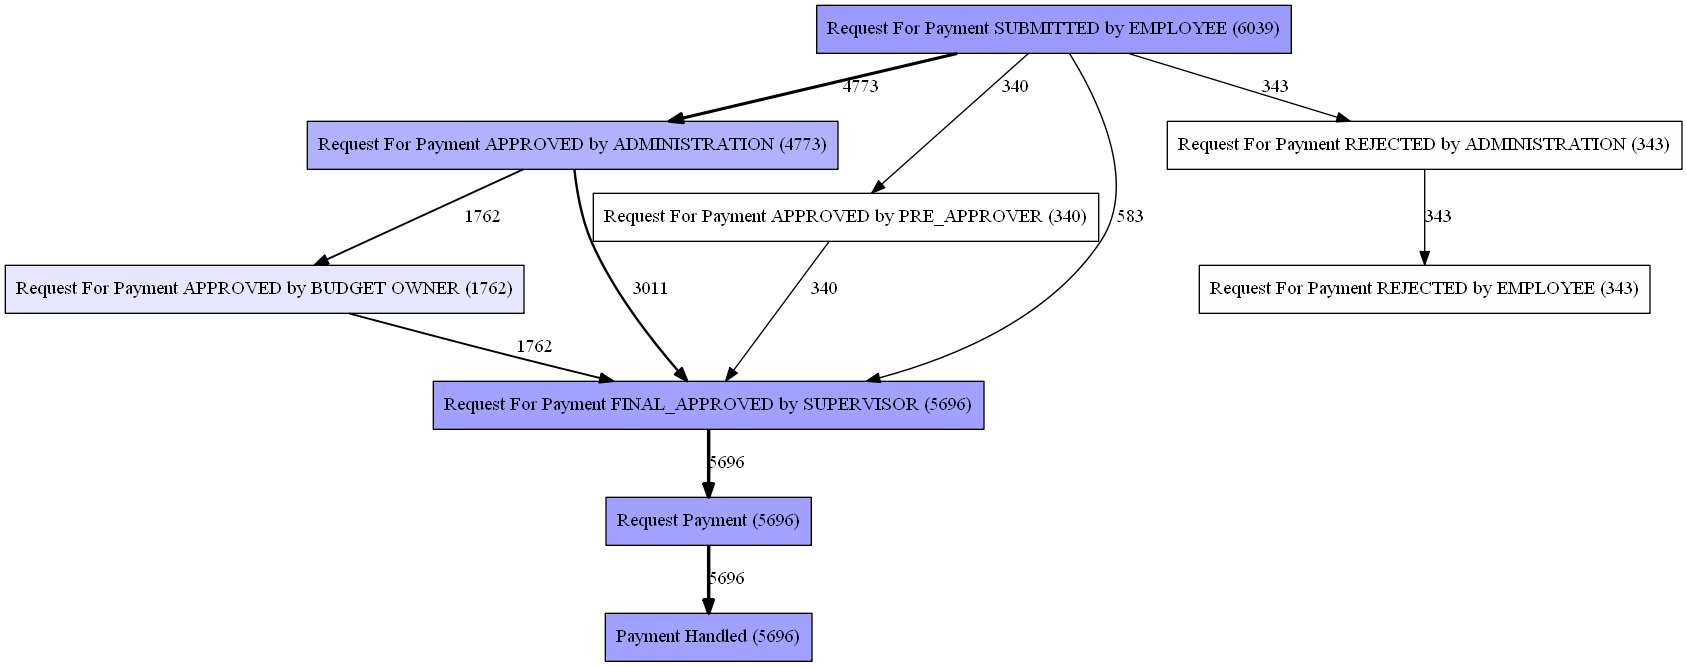

In [44]:
from pm4py.algo.discovery.dfg import factory as dfg_miner
from pm4py.visualization.dfg import factory as dfg_vis

dfg = dfg_miner.apply(filtered_log)
dfg_gviz = dfg_vis.apply(dfg, filtered_log)
dfg_vis.view(dfg_gviz)

In [48]:
print(dfg)
print(dfg.keys())

Counter({('Request For Payment FINAL_APPROVED by SUPERVISOR', 'Request Payment'): 5696, ('Request Payment', 'Payment Handled'): 5696, ('Request For Payment SUBMITTED by EMPLOYEE', 'Request For Payment APPROVED by ADMINISTRATION'): 4773, ('Request For Payment APPROVED by ADMINISTRATION', 'Request For Payment FINAL_APPROVED by SUPERVISOR'): 3011, ('Request For Payment APPROVED by ADMINISTRATION', 'Request For Payment APPROVED by BUDGET OWNER'): 1762, ('Request For Payment APPROVED by BUDGET OWNER', 'Request For Payment FINAL_APPROVED by SUPERVISOR'): 1762, ('Request For Payment SUBMITTED by EMPLOYEE', 'Request For Payment FINAL_APPROVED by SUPERVISOR'): 583, ('Request For Payment SUBMITTED by EMPLOYEE', 'Request For Payment REJECTED by ADMINISTRATION'): 343, ('Request For Payment REJECTED by ADMINISTRATION', 'Request For Payment REJECTED by EMPLOYEE'): 343, ('Request For Payment SUBMITTED by EMPLOYEE', 'Request For Payment APPROVED by PRE_APPROVER'): 340, ('Request For Payment APPROVED b

In [49]:
from pm4py.objects.log.util.log import get_event_labels

activities = get_event_labels(filtered_log, key='concept:name')
queue_dict = {a : Queue() for a in activities}

inputs = {}

for (v, w) in dfg.keys():
    if w not in inputs:
        inputs[w] = []
    inputs[w].append(v)

last_times = {}
for trace in log:
    for event in trace:
        activity = event['concept:name']
        time = event['time:timestamp']

        if activity in inputs:
            for i in inputs[activity]:
                if i in last_times:
                    queue_dict[activity].enter(last_times[i])
                    queue_dict[activity].exit(time)

        last_times[activity] = time

    last_times.clear()

IndentationError: expected an indented block (<ipython-input-49-59f6c9a2efad>, line 9)

In [50]:
token_dict = {a : replay_queue(q) for a, q in queue_dict.items()}

NameError: name 'queue_dict' is not defined